In [11]:
# !pip install catboost

In [86]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
from scipy import stats
from scipy import signal
from scipy.signal import find_peaks
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from lazypredict.Supervised import LazyClassifier

from skopt import BayesSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from catboost import CatBoostClassifier

In [41]:
def make_submission(preds):
    assert len(preds) == 5000
    
    # Read labels
    with open('test_labels_sorted.npy', 'rb') as f:
        test_labels = np.load(f)
    len(test_labels)
    
    submission = pd.DataFrame(columns=['id', 'class'])
    for label, pred in zip(test_labels, preds):
        submission = submission.append({'id': label, 'class': pred}, ignore_index=True)
    return submission

In [42]:
def plot_confusion_matrix(y_val_from_train, y_pred_from_train):
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(confusion_matrix(y_val_from_train, y_pred_from_train))
    cmp.plot(ax=ax)
    plt.show()

In [43]:
train_files = os.listdir('train/train/')
train_files.sort()
train_files[:5]

['10003.csv', '10005.csv', '10006.csv', '10007.csv', '10012.csv']

In [44]:
test_files = os.listdir('test/test/')
test_files.sort()
print(test_files[:5], len(test_files))

['10001.csv', '10002.csv', '10004.csv', '10008.csv', '10009.csv'] 5000


### Play around with scipy stats

In [7]:
arr = [1, 2, 3, 4, -4, 5, 7, -9]
result = stats.describe(arr, ddof=1, bias=False)
result

DescribeResult(nobs=8, minmax=(-9, 7), mean=1.125, variance=27.267857142857142, skewness=-1.1779850539898067, kurtosis=0.9549878223412755)

In [8]:
print(result.minmax[0], result.minmax[1], result.mean, result.variance, result.skewness, result.kurtosis)

-9 7 1.125 27.267857142857142 -1.1779850539898067 0.9549878223412755


# Each axis will have 6 features: min, max, mean (avg), var, skew, kurtosis 

### Let's build X_train

In [9]:
colnames = ['x', 'y', 'z']
N = 9000
features = 18
X_train = np.zeros((N, features))
labels = []

for i, file in enumerate(train_files[:N]):
    
    full_path = f'train/train/{file}'
    temp_df = pd.read_csv(full_path, names=colnames)
#     index = map_file_to_label(file)
#     labels.append(train_labels_map[index])
    
    x = temp_df['x'].to_numpy()
    y = temp_df['y'].to_numpy()
    z = temp_df['z'].to_numpy()
    
    x_stats = stats.describe(x, ddof=1, bias=False)
    y_stats = stats.describe(y, ddof=1, bias=False)
    z_stats = stats.describe(z, ddof=1, bias=False)
    
    min_x, max_x, mean_x, var_x, skew_x, kurt_x = x_stats.minmax[0], x_stats.minmax[1], x_stats.mean, x_stats.variance, x_stats.skewness, x_stats.kurtosis
    min_y, max_y, mean_y, var_y, skew_y, kurt_y = y_stats.minmax[0], y_stats.minmax[1], y_stats.mean, y_stats.variance, y_stats.skewness, y_stats.kurtosis
    min_z, max_z, mean_z, var_z, skew_z, kurt_z = z_stats.minmax[0], z_stats.minmax[1], z_stats.mean, z_stats.variance, z_stats.skewness, z_stats.kurtosis
    
    row = [min_x, max_x, mean_x, var_x, skew_x, kurt_x, min_y, max_y, mean_y, var_y, skew_y, kurt_y, min_z, max_z, mean_z, var_z, skew_z, kurt_z]
    
    X_train[i] = np.array(row)

In [10]:
print(X_train.shape, X_train)

(9000, 18) [[-0.881665    1.044471    0.15901094 ...  0.19705786  0.08181645
   2.89740372]
 [-1.105523    1.126472    0.17454775 ...  0.15018673  0.40781987
   0.76315876]
 [-2.64679     0.034716   -1.61696002 ...  0.17658235  1.32167189
   4.17402587]
 ...
 [-1.569399    0.821211   -0.40611246 ...  0.28822678  0.80417
   1.16722611]
 [-1.094749    1.153407    0.00815229 ...  0.76050044  0.45617288
   1.59482328]
 [-1.136647    0.864905   -0.51763365 ...  0.12288464  0.07169998
  -0.40874916]]


In [11]:
# Save X_train
with open('X_train_18.npy', 'wb') as f:
    np.save(f, X_train)

### Let's build X_test

In [12]:
colnames = ['x', 'y', 'z']
N = 5000
features = 18
X_test = np.zeros((N, features))
labels = []

for i, file in enumerate(test_files[:N]):
    
    full_path = f'test/test/{file}'
    temp_df = pd.read_csv(full_path, names=colnames)
#     index = map_file_to_label(file)
#     labels.append(train_labels_map[index])
    
    x = temp_df['x'].to_numpy()
    y = temp_df['y'].to_numpy()
    z = temp_df['z'].to_numpy()
    
    x_stats = stats.describe(x, ddof=1, bias=False)
    y_stats = stats.describe(y, ddof=1, bias=False)
    z_stats = stats.describe(z, ddof=1, bias=False)
    
    min_x, max_x, mean_x, var_x, skew_x, kurt_x = x_stats.minmax[0], x_stats.minmax[1], x_stats.mean, x_stats.variance, x_stats.skewness, x_stats.kurtosis
    min_y, max_y, mean_y, var_y, skew_y, kurt_y = y_stats.minmax[0], y_stats.minmax[1], y_stats.mean, y_stats.variance, y_stats.skewness, y_stats.kurtosis
    min_z, max_z, mean_z, var_z, skew_z, kurt_z = z_stats.minmax[0], z_stats.minmax[1], z_stats.mean, z_stats.variance, z_stats.skewness, z_stats.kurtosis
    
    row = [min_x, max_x, mean_x, var_x, skew_x, kurt_x, min_y, max_y, mean_y, var_y, skew_y, kurt_y, min_z, max_z, mean_z, var_z, skew_z, kurt_z]
    
    X_test[i] = np.array(row)

In [13]:
print(X_test.shape, X_test)

(5000, 18) [[-1.83755000e+00  1.38265100e+00 -3.05412347e-01 ...  9.37497753e-01
  -4.17014118e-01  1.37907310e-01]
 [-1.74357700e+00  1.61488900e+00 -3.54157081e-01 ...  1.94242478e-01
  -7.87082924e-02 -8.37285797e-01]
 [-1.87047000e+00 -2.16077000e-01 -8.47212227e-01 ...  1.53414959e-01
  -1.34689977e-01 -9.68187625e-02]
 ...
 [-6.30872000e-01  6.78756000e-01  4.29758667e-03 ...  2.36459138e-01
   2.33558489e-01 -1.78889974e-01]
 [-2.13143800e+00  4.72850000e-02 -1.05151830e+00 ...  2.32245207e-01
   7.93159889e-02 -8.27629220e-01]
 [-1.54605600e+00  2.98677000e-01 -5.40031205e-01 ...  4.27016372e-01
  -9.06280629e-01  5.68906353e+00]]


In [14]:
# Save X_test
with open('X_test_18.npy', 'wb') as f:
    np.save(f, X_test)

In [15]:
# Load y_train
with open('y_train_15.npy', 'rb') as f:
    y_train = np.load(f)
print(y_train.shape)
y_train

FileNotFoundError: [Errno 2] No such file or directory: 'y_train_15.npy'

### Let's try quick Lazy Classifier

In [29]:
# Create validation data
# Train/test sets
X_train_from_train, X_val_from_train, y_train_from_train, y_val_from_train = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42
)

In [35]:
# Lazy Classifier
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_from_train, X_val_from_train, y_train_from_train, y_val_from_train)
models

100%|██████████| 29/29 [00:17<00:00,  1.66it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.94,0.94,None,0.94,0.47
LGBMClassifier,0.94,0.94,None,0.94,1.04
RandomForestClassifier,0.93,0.93,None,0.93,1.66
BaggingClassifier,0.89,0.89,None,0.89,0.68
QuadraticDiscriminantAnalysis,0.89,0.89,None,0.89,0.02
SVC,0.89,0.88,None,0.89,0.72
LogisticRegression,0.88,0.87,None,0.88,0.43
LinearDiscriminantAnalysis,0.87,0.87,None,0.87,0.05
LabelPropagation,0.86,0.86,None,0.86,1.60


# We build upon the previous step, and we add 6 more features relating to the acceleration's amplitude distribution

### Let's play around with operations

In [ ]:
x = [1, 2, 3]
y = [1, 2, 4]
z = [1, 4, 3]
amp_arr = []

# Let's calculate the sqrt(x + y + z)
for xx, yy, zz in zip(x, y, z):
    amp = np.sqrt(xx**2 + yy**2 + zz**2)
    amp_arr.append(amp)
    
amp_arr

## Let's build X_train

In [ ]:
colnames = ['x', 'y', 'z']
N = 9000
features = 24
X_train = np.zeros((N, features))
labels = []

for i, file in enumerate(train_files[:N]):
    
    full_path = f'train/train/{file}'
    temp_df = pd.read_csv(full_path, names=colnames)
#     index = map_file_to_label(file)
#     labels.append(train_labels_map[index])
    
    x = temp_df['x'].to_numpy()
    y = temp_df['y'].to_numpy()
    z = temp_df['z'].to_numpy()
    
    amp_arr = []
    # Let's calculate the sqrt(x + y + z) -> amplitude of acceleration at each step
    for xx, yy, zz in zip(x, y, z):
        amp = np.sqrt(xx**2 + yy**2 + zz**2)
        amp_arr.append(amp)
    
    x_stats = stats.describe(x, ddof=1, bias=False)
    y_stats = stats.describe(y, ddof=1, bias=False)
    z_stats = stats.describe(z, ddof=1, bias=False)
    a_stats = stats.describe(amp_arr, ddof=1, bias=False)
    
    min_x, max_x, mean_x, var_x, skew_x, kurt_x = x_stats.minmax[0], x_stats.minmax[1], x_stats.mean, x_stats.variance, x_stats.skewness, x_stats.kurtosis
    min_y, max_y, mean_y, var_y, skew_y, kurt_y = y_stats.minmax[0], y_stats.minmax[1], y_stats.mean, y_stats.variance, y_stats.skewness, y_stats.kurtosis
    min_z, max_z, mean_z, var_z, skew_z, kurt_z = z_stats.minmax[0], z_stats.minmax[1], z_stats.mean, z_stats.variance, z_stats.skewness, z_stats.kurtosis
    min_a, max_a, mean_a, var_a, skew_a, kurt_a = a_stats.minmax[0], a_stats.minmax[1], a_stats.mean, a_stats.variance, a_stats.skewness, a_stats.kurtosis
    
    row = [min_x, max_x, mean_x, var_x, skew_x, kurt_x, \
           min_y, max_y, mean_y, var_y, skew_y, kurt_y, \
           min_z, max_z, mean_z, var_z, skew_z, kurt_z, \
           min_a, max_a, mean_a, var_a, skew_a, kurt_a]
    
    X_train[i] = np.array(row)

In [ ]:
print(X_train.shape, X_train)

In [ ]:
# Save X_train
with open('X_train_24.npy', 'wb') as f:
    np.save(f, X_train)

## Let's build X_test

In [ ]:
colnames = ['x', 'y', 'z']
N = 5000
features = 24
X_test = np.zeros((N, features))
labels = []

for i, file in enumerate(test_files[:N]):
    
    full_path = f'test/test/{file}'
    temp_df = pd.read_csv(full_path, names=colnames)
#     index = map_file_to_label(file)
#     labels.append(train_labels_map[index])
    
    x = temp_df['x'].to_numpy()
    y = temp_df['y'].to_numpy()
    z = temp_df['z'].to_numpy()
    
    amp_arr = []
    # Let's calculate the sqrt(x + y + z) -> amplitude of acceleration at each step
    for xx, yy, zz in zip(x, y, z):
        amp = np.sqrt(xx**2 + yy**2 + zz**2)
        amp_arr.append(amp)
    
    x_stats = stats.describe(x, ddof=1, bias=False)
    y_stats = stats.describe(y, ddof=1, bias=False)
    z_stats = stats.describe(z, ddof=1, bias=False)
    a_stats = stats.describe(amp_arr, ddof=1, bias=False)
    
    min_x, max_x, mean_x, var_x, skew_x, kurt_x = x_stats.minmax[0], x_stats.minmax[1], x_stats.mean, x_stats.variance, x_stats.skewness, x_stats.kurtosis
    min_y, max_y, mean_y, var_y, skew_y, kurt_y = y_stats.minmax[0], y_stats.minmax[1], y_stats.mean, y_stats.variance, y_stats.skewness, y_stats.kurtosis
    min_z, max_z, mean_z, var_z, skew_z, kurt_z = z_stats.minmax[0], z_stats.minmax[1], z_stats.mean, z_stats.variance, z_stats.skewness, z_stats.kurtosis
    min_a, max_a, mean_a, var_a, skew_a, kurt_a = a_stats.minmax[0], a_stats.minmax[1], a_stats.mean, a_stats.variance, a_stats.skewness, a_stats.kurtosis
    
    row = [min_x, max_x, mean_x, var_x, skew_x, kurt_x, \
           min_y, max_y, mean_y, var_y, skew_y, kurt_y, \
           min_z, max_z, mean_z, var_z, skew_z, kurt_z, \
           min_a, max_a, mean_a, var_a, skew_a, kurt_a]
    
    X_test[i] = np.array(row)

In [ ]:
print(X_test.shape, X_test)

In [ ]:
# Save X_test
with open('X_test_24.npy', 'wb') as f:
    np.save(f, X_test)

## Create Train-Validation Set

In [55]:
# Create validation data
# Train/test sets
X_train_from_train, X_val_from_train, y_train_from_train, y_val_from_train = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42
)

print(X_train_from_train.shape, X_val_from_train.shape, y_train_from_train.shape, y_val_from_train.shape)

(7650, 43) (1350, 43) (7650,) (1350,)


### Let's try quick Lazy Classifier

In [56]:
# Lazy Classifier
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_from_train, X_val_from_train, y_train_from_train, y_val_from_train)
models

100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.96,0.96,None,0.96,1.22
RandomForestClassifier,0.95,0.95,None,0.95,2.20
ExtraTreesClassifier,0.95,0.95,None,0.95,0.51
SVC,0.94,0.93,None,0.94,0.73
LogisticRegression,0.93,0.93,None,0.93,0.40
QuadraticDiscriminantAnalysis,0.93,0.93,None,0.93,0.02
BaggingClassifier,0.93,0.93,None,0.93,1.42
LinearDiscriminantAnalysis,0.91,0.91,None,0.91,0.03
LinearSVC,0.91,0.91,None,0.91,0.93


# Load Data

In [38]:
# Load X_train
with open('X_train_24.npy', 'rb') as f:
    X_train = np.load(f)
print(X_train.shape)
X_train

(9000, 24)


array([[-0.881665  ,  1.044471  ,  0.15901094, ...,  0.14329861,
         0.29854766,  1.72087463],
       [-1.105523  ,  1.126472  ,  0.17454775, ...,  0.18043879,
        -0.20785722, -0.07204283],
       [-2.64679   ,  0.034716  , -1.61696002, ...,  0.09802465,
         1.79855361,  6.20649724],
       ...,
       [-1.569399  ,  0.821211  , -0.40611246, ...,  0.17958009,
         0.16936675,  0.38527156],
       [-1.094749  ,  1.153407  ,  0.00815229, ...,  0.59477687,
         0.09159904,  0.32757404],
       [-1.136647  ,  0.864905  , -0.51763365, ...,  0.1212113 ,
        -0.98257849, -0.01119592]])

In [54]:
# Load y_train
with open('y_train.npy', 'rb') as f:
    y_train = np.load(f)
print(y_train.shape)
y_train

(9000,)


array([ 7, 13,  6, ...,  3,  3, 18], dtype=int64)

In [40]:
# Load X_test
with open('X_test_24.npy', 'rb') as f:
    X_test = np.load(f)
print(X_test.shape)
X_test

(5000, 24)


array([[-1.83755000e+00,  1.38265100e+00, -3.05412347e-01, ...,
         6.41653222e-01, -2.70378930e-01, -6.56709631e-01],
       [-1.74357700e+00,  1.61488900e+00, -3.54157081e-01, ...,
         1.26971131e-01, -1.12422501e-01, -3.54827836e-01],
       [-1.87047000e+00, -2.16077000e-01, -8.47212227e-01, ...,
         9.30784537e-02,  2.81907035e-01,  6.14209125e-01],
       ...,
       [-6.30872000e-01,  6.78756000e-01,  4.29758667e-03, ...,
         2.57441289e-01,  3.60590805e-01, -7.93530596e-01],
       [-2.13143800e+00,  4.72850000e-02, -1.05151830e+00, ...,
         1.49931026e-01,  1.18705530e-02, -1.01464047e+00],
       [-1.54605600e+00,  2.98677000e-01, -5.40031205e-01, ...,
         2.83123897e-01, -4.80041145e-01,  5.33925135e+00]])

In [75]:
# Create validation data
# Train/test sets
X_train_from_train, X_val_from_train, y_train_from_train, y_val_from_train = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42
)

### Quick experiment with ETC

In [57]:
etc = ExtraTreesClassifier(random_state=42, n_jobs=-1, warm_start=True, class_weight="balanced_subsample", max_depth=70, min_samples_leaf=1, min_samples_split=2, n_estimators=500)

In [58]:
%%time
etc.fit(X_train_from_train, y_train_from_train)

Wall time: 475 ms


ExtraTreesClassifier(class_weight='balanced_subsample', max_depth=70,
                     n_estimators=500, n_jobs=-1, random_state=42,
                     warm_start=True)

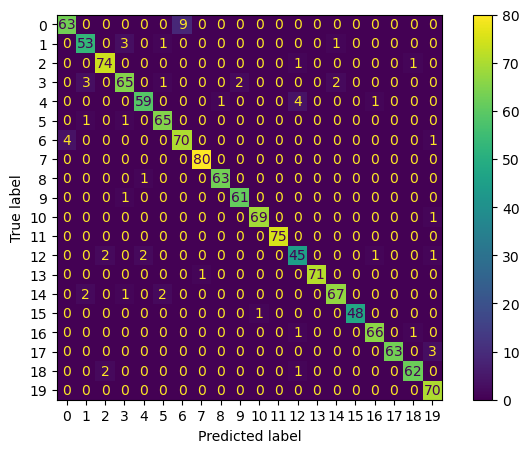

In [59]:
y_pred_from_train = etc.predict(X_val_from_train)
plot_confusion_matrix(y_val_from_train, y_pred_from_train)

In [60]:
accuracy_score(y_val_from_train, y_pred_from_train) #0.957

0.9548148148148148

### Quick experiment with SVC

In [65]:
svc = SVC(C=150, degree=2, gamma="auto", kernel="poly")

In [66]:
%%time
svc.fit(X_train_from_train, y_train_from_train)

Wall time: 5.58 s


SVC(C=150, degree=2, gamma='auto', kernel='poly')

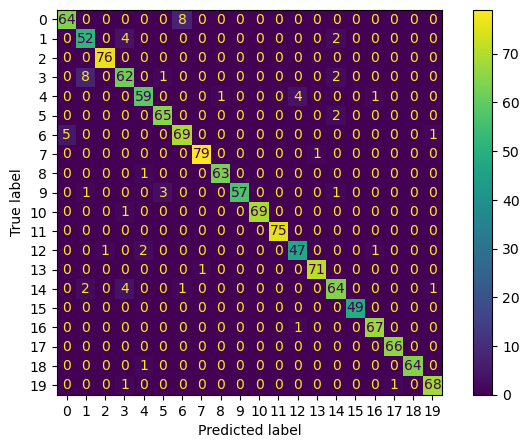

In [67]:
y_pred_from_train = svc.predict(X_val_from_train)
plot_confusion_matrix(y_val_from_train, y_pred_from_train)

In [68]:
accuracy_score(y_val_from_train, y_pred_from_train) #0.95259

0.9525925925925925

### Quick example with Catboost

In [79]:
cbc = CatBoostClassifier()

In [80]:
%%time
cbc.fit(X_train_from_train, y_train_from_train)

Learning rate set to 0.087779
0:	learn: 2.4774351	total: 47.8ms	remaining: 47.8s
1:	learn: 2.1528139	total: 96.7ms	remaining: 48.3s
2:	learn: 1.9127705	total: 144ms	remaining: 48s
3:	learn: 1.7384667	total: 194ms	remaining: 48.3s
4:	learn: 1.6149172	total: 240ms	remaining: 47.8s
5:	learn: 1.4921480	total: 291ms	remaining: 48.1s
6:	learn: 1.3928044	total: 337ms	remaining: 47.8s
7:	learn: 1.3022269	total: 384ms	remaining: 47.7s
8:	learn: 1.2119736	total: 434ms	remaining: 47.8s
9:	learn: 1.1417865	total: 481ms	remaining: 47.6s
10:	learn: 1.0824928	total: 530ms	remaining: 47.6s
11:	learn: 1.0270913	total: 576ms	remaining: 47.4s
12:	learn: 0.9807866	total: 623ms	remaining: 47.3s
13:	learn: 0.9387692	total: 671ms	remaining: 47.2s
14:	learn: 0.8970428	total: 719ms	remaining: 47.2s
15:	learn: 0.8559079	total: 768ms	remaining: 47.2s
16:	learn: 0.8245037	total: 818ms	remaining: 47.3s
17:	learn: 0.7899935	total: 867ms	remaining: 47.3s
18:	learn: 0.7577495	total: 917ms	remaining: 47.3s
19:	learn: 

164:	learn: 0.1523969	total: 7.9s	remaining: 40s
165:	learn: 0.1516920	total: 7.95s	remaining: 39.9s
166:	learn: 0.1508088	total: 7.99s	remaining: 39.9s
167:	learn: 0.1502919	total: 8.04s	remaining: 39.8s
168:	learn: 0.1493025	total: 8.09s	remaining: 39.8s
169:	learn: 0.1485299	total: 8.13s	remaining: 39.7s
170:	learn: 0.1477069	total: 8.18s	remaining: 39.7s
171:	learn: 0.1470200	total: 8.23s	remaining: 39.6s
172:	learn: 0.1463577	total: 8.28s	remaining: 39.6s
173:	learn: 0.1456590	total: 8.32s	remaining: 39.5s
174:	learn: 0.1449865	total: 8.37s	remaining: 39.5s
175:	learn: 0.1446925	total: 8.42s	remaining: 39.4s
176:	learn: 0.1440852	total: 8.47s	remaining: 39.4s
177:	learn: 0.1435492	total: 8.52s	remaining: 39.3s
178:	learn: 0.1427945	total: 8.56s	remaining: 39.3s
179:	learn: 0.1423329	total: 8.61s	remaining: 39.2s
180:	learn: 0.1416212	total: 8.66s	remaining: 39.2s
181:	learn: 0.1408092	total: 8.71s	remaining: 39.1s
182:	learn: 0.1405284	total: 8.75s	remaining: 39.1s
183:	learn: 0.1

324:	learn: 0.0861730	total: 15.5s	remaining: 32.2s
325:	learn: 0.0858270	total: 15.6s	remaining: 32.2s
326:	learn: 0.0856220	total: 15.6s	remaining: 32.1s
327:	learn: 0.0855145	total: 15.6s	remaining: 32.1s
328:	learn: 0.0852789	total: 15.7s	remaining: 32s
329:	learn: 0.0850447	total: 15.7s	remaining: 32s
330:	learn: 0.0848716	total: 15.8s	remaining: 31.9s
331:	learn: 0.0846216	total: 15.8s	remaining: 31.9s
332:	learn: 0.0843658	total: 15.9s	remaining: 31.8s
333:	learn: 0.0840582	total: 15.9s	remaining: 31.8s
334:	learn: 0.0838336	total: 16s	remaining: 31.7s
335:	learn: 0.0836989	total: 16s	remaining: 31.7s
336:	learn: 0.0835722	total: 16.1s	remaining: 31.6s
337:	learn: 0.0832850	total: 16.1s	remaining: 31.6s
338:	learn: 0.0830370	total: 16.2s	remaining: 31.5s
339:	learn: 0.0828971	total: 16.2s	remaining: 31.5s
340:	learn: 0.0826436	total: 16.3s	remaining: 31.4s
341:	learn: 0.0822615	total: 16.3s	remaining: 31.4s
342:	learn: 0.0819455	total: 16.4s	remaining: 31.3s
343:	learn: 0.081760

484:	learn: 0.0578943	total: 23.2s	remaining: 24.6s
485:	learn: 0.0578297	total: 23.2s	remaining: 24.5s
486:	learn: 0.0577611	total: 23.3s	remaining: 24.5s
487:	learn: 0.0576202	total: 23.3s	remaining: 24.4s
488:	learn: 0.0573538	total: 23.4s	remaining: 24.4s
489:	learn: 0.0572033	total: 23.4s	remaining: 24.4s
490:	learn: 0.0570518	total: 23.4s	remaining: 24.3s
491:	learn: 0.0569532	total: 23.5s	remaining: 24.3s
492:	learn: 0.0568514	total: 23.5s	remaining: 24.2s
493:	learn: 0.0567457	total: 23.6s	remaining: 24.2s
494:	learn: 0.0566864	total: 23.6s	remaining: 24.1s
495:	learn: 0.0565170	total: 23.7s	remaining: 24.1s
496:	learn: 0.0563454	total: 23.7s	remaining: 24s
497:	learn: 0.0562451	total: 23.8s	remaining: 24s
498:	learn: 0.0559655	total: 23.8s	remaining: 23.9s
499:	learn: 0.0557740	total: 23.9s	remaining: 23.9s
500:	learn: 0.0556148	total: 23.9s	remaining: 23.8s
501:	learn: 0.0554826	total: 24s	remaining: 23.8s
502:	learn: 0.0553082	total: 24s	remaining: 23.7s
503:	learn: 0.055157

644:	learn: 0.0402571	total: 30.8s	remaining: 16.9s
645:	learn: 0.0402024	total: 30.8s	remaining: 16.9s
646:	learn: 0.0401150	total: 30.9s	remaining: 16.8s
647:	learn: 0.0400060	total: 30.9s	remaining: 16.8s
648:	learn: 0.0399231	total: 31s	remaining: 16.7s
649:	learn: 0.0398848	total: 31s	remaining: 16.7s
650:	learn: 0.0398495	total: 31.1s	remaining: 16.6s
651:	learn: 0.0397951	total: 31.1s	remaining: 16.6s
652:	learn: 0.0397499	total: 31.2s	remaining: 16.6s
653:	learn: 0.0396985	total: 31.2s	remaining: 16.5s
654:	learn: 0.0396294	total: 31.2s	remaining: 16.5s
655:	learn: 0.0395796	total: 31.3s	remaining: 16.4s
656:	learn: 0.0395141	total: 31.3s	remaining: 16.4s
657:	learn: 0.0394373	total: 31.4s	remaining: 16.3s
658:	learn: 0.0393936	total: 31.4s	remaining: 16.3s
659:	learn: 0.0393478	total: 31.5s	remaining: 16.2s
660:	learn: 0.0392617	total: 31.5s	remaining: 16.2s
661:	learn: 0.0391714	total: 31.6s	remaining: 16.1s
662:	learn: 0.0390949	total: 31.6s	remaining: 16.1s
663:	learn: 0.03

804:	learn: 0.0295220	total: 38.4s	remaining: 9.3s
805:	learn: 0.0294681	total: 38.5s	remaining: 9.26s
806:	learn: 0.0294206	total: 38.5s	remaining: 9.21s
807:	learn: 0.0293836	total: 38.6s	remaining: 9.16s
808:	learn: 0.0293130	total: 38.6s	remaining: 9.11s
809:	learn: 0.0292191	total: 38.6s	remaining: 9.06s
810:	learn: 0.0291863	total: 38.7s	remaining: 9.02s
811:	learn: 0.0291143	total: 38.7s	remaining: 8.97s
812:	learn: 0.0290765	total: 38.8s	remaining: 8.92s
813:	learn: 0.0290205	total: 38.8s	remaining: 8.87s
814:	learn: 0.0289840	total: 38.9s	remaining: 8.83s
815:	learn: 0.0289166	total: 38.9s	remaining: 8.78s
816:	learn: 0.0288906	total: 39s	remaining: 8.73s
817:	learn: 0.0288193	total: 39s	remaining: 8.68s
818:	learn: 0.0287658	total: 39.1s	remaining: 8.63s
819:	learn: 0.0287021	total: 39.1s	remaining: 8.59s
820:	learn: 0.0286614	total: 39.2s	remaining: 8.54s
821:	learn: 0.0286215	total: 39.2s	remaining: 8.49s
822:	learn: 0.0285712	total: 39.3s	remaining: 8.44s
823:	learn: 0.028

964:	learn: 0.0227091	total: 46s	remaining: 1.67s
965:	learn: 0.0226815	total: 46.1s	remaining: 1.62s
966:	learn: 0.0226618	total: 46.1s	remaining: 1.57s
967:	learn: 0.0226269	total: 46.2s	remaining: 1.53s
968:	learn: 0.0225812	total: 46.2s	remaining: 1.48s
969:	learn: 0.0225234	total: 46.3s	remaining: 1.43s
970:	learn: 0.0224945	total: 46.3s	remaining: 1.38s
971:	learn: 0.0224647	total: 46.4s	remaining: 1.33s
972:	learn: 0.0224385	total: 46.4s	remaining: 1.29s
973:	learn: 0.0223961	total: 46.5s	remaining: 1.24s
974:	learn: 0.0223771	total: 46.5s	remaining: 1.19s
975:	learn: 0.0223383	total: 46.6s	remaining: 1.14s
976:	learn: 0.0223085	total: 46.6s	remaining: 1.1s
977:	learn: 0.0222859	total: 46.7s	remaining: 1.05s
978:	learn: 0.0222563	total: 46.7s	remaining: 1s
979:	learn: 0.0222402	total: 46.8s	remaining: 954ms
980:	learn: 0.0222147	total: 46.8s	remaining: 906ms
981:	learn: 0.0221909	total: 46.8s	remaining: 859ms
982:	learn: 0.0221570	total: 46.9s	remaining: 811ms
983:	learn: 0.0221

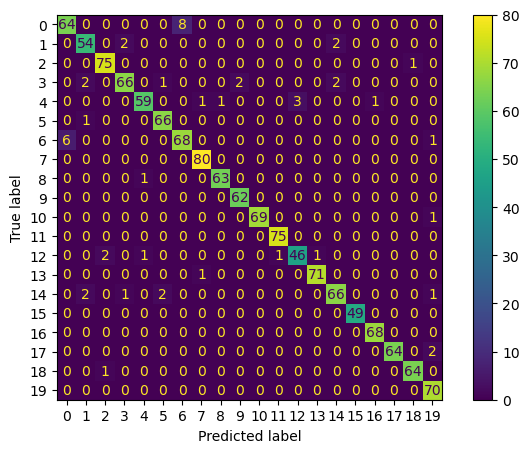

In [81]:
y_pred_from_train = cbc.predict(X_val_from_train)
plot_confusion_matrix(y_val_from_train, y_pred_from_train)

In [82]:
accuracy_score(y_val_from_train, y_pred_from_train) #96.22

0.9622222222222222

### Train on the whole data

In [41]:
cbc = CatBoostClassifier()
cbc.fit(X_train, y_train)

Learning rate set to 0.088509
0:	learn: 2.4054464	total: 33.1ms	remaining: 33s
1:	learn: 2.0626158	total: 65.4ms	remaining: 32.6s
2:	learn: 1.8408057	total: 99.3ms	remaining: 33s
3:	learn: 1.6800571	total: 131ms	remaining: 32.7s
4:	learn: 1.5467220	total: 161ms	remaining: 32.1s
5:	learn: 1.4355339	total: 193ms	remaining: 32s
6:	learn: 1.3447577	total: 225ms	remaining: 31.9s
7:	learn: 1.2635675	total: 257ms	remaining: 31.9s
8:	learn: 1.1871264	total: 289ms	remaining: 31.8s
9:	learn: 1.1176112	total: 321ms	remaining: 31.8s
10:	learn: 1.0576895	total: 352ms	remaining: 31.7s
11:	learn: 1.0086396	total: 383ms	remaining: 31.5s
12:	learn: 0.9641736	total: 413ms	remaining: 31.4s
13:	learn: 0.9257344	total: 445ms	remaining: 31.3s
14:	learn: 0.8853367	total: 476ms	remaining: 31.3s
15:	learn: 0.8491656	total: 508ms	remaining: 31.3s
16:	learn: 0.8189029	total: 543ms	remaining: 31.4s
17:	learn: 0.7875816	total: 576ms	remaining: 31.4s
18:	learn: 0.7600466	total: 606ms	remaining: 31.3s
19:	learn: 0.7

160:	learn: 0.1759522	total: 5.2s	remaining: 27.1s
161:	learn: 0.1753371	total: 5.24s	remaining: 27.1s
162:	learn: 0.1745847	total: 5.27s	remaining: 27.1s
163:	learn: 0.1738214	total: 5.3s	remaining: 27s
164:	learn: 0.1735407	total: 5.33s	remaining: 27s
165:	learn: 0.1730820	total: 5.37s	remaining: 27s
166:	learn: 0.1722857	total: 5.4s	remaining: 26.9s
167:	learn: 0.1717676	total: 5.43s	remaining: 26.9s
168:	learn: 0.1709873	total: 5.46s	remaining: 26.9s
169:	learn: 0.1700713	total: 5.5s	remaining: 26.8s
170:	learn: 0.1695365	total: 5.53s	remaining: 26.8s
171:	learn: 0.1690225	total: 5.56s	remaining: 26.8s
172:	learn: 0.1685453	total: 5.59s	remaining: 26.7s
173:	learn: 0.1680333	total: 5.62s	remaining: 26.7s
174:	learn: 0.1673879	total: 5.66s	remaining: 26.7s
175:	learn: 0.1663880	total: 5.69s	remaining: 26.6s
176:	learn: 0.1655162	total: 5.72s	remaining: 26.6s
177:	learn: 0.1647659	total: 5.75s	remaining: 26.6s
178:	learn: 0.1642378	total: 5.79s	remaining: 26.5s
179:	learn: 0.1636178	

319:	learn: 0.1019680	total: 10.4s	remaining: 22.1s
320:	learn: 0.1018121	total: 10.4s	remaining: 22s
321:	learn: 0.1016422	total: 10.4s	remaining: 22s
322:	learn: 0.1014081	total: 10.5s	remaining: 22s
323:	learn: 0.1011064	total: 10.5s	remaining: 21.9s
324:	learn: 0.1008613	total: 10.5s	remaining: 21.9s
325:	learn: 0.1004371	total: 10.6s	remaining: 21.9s
326:	learn: 0.0999153	total: 10.6s	remaining: 21.8s
327:	learn: 0.0997886	total: 10.6s	remaining: 21.8s
328:	learn: 0.0993669	total: 10.7s	remaining: 21.8s
329:	learn: 0.0991564	total: 10.7s	remaining: 21.7s
330:	learn: 0.0989437	total: 10.7s	remaining: 21.7s
331:	learn: 0.0985953	total: 10.8s	remaining: 21.7s
332:	learn: 0.0983046	total: 10.8s	remaining: 21.7s
333:	learn: 0.0979645	total: 10.8s	remaining: 21.6s
334:	learn: 0.0977876	total: 10.9s	remaining: 21.6s
335:	learn: 0.0976360	total: 10.9s	remaining: 21.6s
336:	learn: 0.0973773	total: 10.9s	remaining: 21.5s
337:	learn: 0.0969864	total: 11s	remaining: 21.5s
338:	learn: 0.096753

479:	learn: 0.0665295	total: 15.6s	remaining: 16.9s
480:	learn: 0.0664217	total: 15.6s	remaining: 16.8s
481:	learn: 0.0663479	total: 15.6s	remaining: 16.8s
482:	learn: 0.0661303	total: 15.7s	remaining: 16.8s
483:	learn: 0.0659882	total: 15.7s	remaining: 16.7s
484:	learn: 0.0658680	total: 15.7s	remaining: 16.7s
485:	learn: 0.0657564	total: 15.8s	remaining: 16.7s
486:	learn: 0.0656647	total: 15.8s	remaining: 16.6s
487:	learn: 0.0653916	total: 15.8s	remaining: 16.6s
488:	learn: 0.0653092	total: 15.9s	remaining: 16.6s
489:	learn: 0.0651917	total: 15.9s	remaining: 16.5s
490:	learn: 0.0650473	total: 15.9s	remaining: 16.5s
491:	learn: 0.0649145	total: 16s	remaining: 16.5s
492:	learn: 0.0648205	total: 16s	remaining: 16.5s
493:	learn: 0.0647075	total: 16s	remaining: 16.4s
494:	learn: 0.0645647	total: 16.1s	remaining: 16.4s
495:	learn: 0.0643871	total: 16.1s	remaining: 16.4s
496:	learn: 0.0642705	total: 16.1s	remaining: 16.3s
497:	learn: 0.0641083	total: 16.2s	remaining: 16.3s
498:	learn: 0.0640

640:	learn: 0.0479604	total: 20.8s	remaining: 11.7s
641:	learn: 0.0477831	total: 20.8s	remaining: 11.6s
642:	learn: 0.0476891	total: 20.9s	remaining: 11.6s
643:	learn: 0.0476239	total: 20.9s	remaining: 11.6s
644:	learn: 0.0475666	total: 20.9s	remaining: 11.5s
645:	learn: 0.0474127	total: 21s	remaining: 11.5s
646:	learn: 0.0473702	total: 21s	remaining: 11.5s
647:	learn: 0.0472477	total: 21s	remaining: 11.4s
648:	learn: 0.0471647	total: 21.1s	remaining: 11.4s
649:	learn: 0.0471065	total: 21.1s	remaining: 11.4s
650:	learn: 0.0470476	total: 21.1s	remaining: 11.3s
651:	learn: 0.0469495	total: 21.2s	remaining: 11.3s
652:	learn: 0.0468677	total: 21.2s	remaining: 11.3s
653:	learn: 0.0467985	total: 21.2s	remaining: 11.2s
654:	learn: 0.0466849	total: 21.3s	remaining: 11.2s
655:	learn: 0.0465683	total: 21.3s	remaining: 11.2s
656:	learn: 0.0465257	total: 21.3s	remaining: 11.1s
657:	learn: 0.0464313	total: 21.4s	remaining: 11.1s
658:	learn: 0.0463337	total: 21.4s	remaining: 11.1s
659:	learn: 0.0462

801:	learn: 0.0355804	total: 26.1s	remaining: 6.44s
802:	learn: 0.0355238	total: 26.1s	remaining: 6.4s
803:	learn: 0.0354819	total: 26.1s	remaining: 6.37s
804:	learn: 0.0354285	total: 26.2s	remaining: 6.34s
805:	learn: 0.0353547	total: 26.2s	remaining: 6.31s
806:	learn: 0.0353037	total: 26.2s	remaining: 6.28s
807:	learn: 0.0352554	total: 26.3s	remaining: 6.24s
808:	learn: 0.0351560	total: 26.3s	remaining: 6.21s
809:	learn: 0.0351130	total: 26.3s	remaining: 6.18s
810:	learn: 0.0350576	total: 26.4s	remaining: 6.15s
811:	learn: 0.0350003	total: 26.4s	remaining: 6.11s
812:	learn: 0.0349467	total: 26.4s	remaining: 6.08s
813:	learn: 0.0349009	total: 26.5s	remaining: 6.05s
814:	learn: 0.0348517	total: 26.5s	remaining: 6.02s
815:	learn: 0.0348218	total: 26.5s	remaining: 5.99s
816:	learn: 0.0347712	total: 26.6s	remaining: 5.95s
817:	learn: 0.0347259	total: 26.6s	remaining: 5.92s
818:	learn: 0.0346790	total: 26.6s	remaining: 5.89s
819:	learn: 0.0345866	total: 26.7s	remaining: 5.86s
820:	learn: 0

962:	learn: 0.0275727	total: 31.3s	remaining: 1.2s
963:	learn: 0.0275053	total: 31.4s	remaining: 1.17s
964:	learn: 0.0274641	total: 31.4s	remaining: 1.14s
965:	learn: 0.0274114	total: 31.4s	remaining: 1.1s
966:	learn: 0.0273836	total: 31.5s	remaining: 1.07s
967:	learn: 0.0273357	total: 31.5s	remaining: 1.04s
968:	learn: 0.0272891	total: 31.5s	remaining: 1.01s
969:	learn: 0.0272722	total: 31.6s	remaining: 976ms
970:	learn: 0.0272311	total: 31.6s	remaining: 943ms
971:	learn: 0.0271996	total: 31.6s	remaining: 911ms
972:	learn: 0.0271411	total: 31.6s	remaining: 878ms
973:	learn: 0.0271070	total: 31.7s	remaining: 846ms
974:	learn: 0.0270471	total: 31.7s	remaining: 813ms
975:	learn: 0.0270170	total: 31.7s	remaining: 781ms
976:	learn: 0.0269788	total: 31.8s	remaining: 748ms
977:	learn: 0.0269538	total: 31.8s	remaining: 715ms
978:	learn: 0.0269213	total: 31.8s	remaining: 683ms
979:	learn: 0.0268753	total: 31.9s	remaining: 650ms
980:	learn: 0.0268482	total: 31.9s	remaining: 618ms
981:	learn: 0.

In [46]:
preds = cbc.predict(X_test)
preds = [a[0] for a in preds]
preds

[3,
 4,
 5,
 20,
 5,
 13,
 9,
 4,
 5,
 3,
 16,
 9,
 2,
 8,
 17,
 10,
 19,
 5,
 7,
 18,
 17,
 18,
 12,
 7,
 16,
 18,
 8,
 2,
 16,
 3,
 16,
 6,
 10,
 9,
 4,
 3,
 6,
 20,
 5,
 1,
 5,
 10,
 3,
 3,
 1,
 3,
 18,
 18,
 10,
 20,
 17,
 3,
 7,
 15,
 3,
 12,
 16,
 16,
 8,
 17,
 15,
 4,
 17,
 13,
 9,
 13,
 20,
 8,
 4,
 15,
 14,
 20,
 16,
 9,
 12,
 8,
 5,
 6,
 18,
 9,
 17,
 8,
 17,
 8,
 11,
 12,
 19,
 12,
 5,
 17,
 17,
 16,
 18,
 5,
 11,
 1,
 10,
 5,
 5,
 11,
 5,
 16,
 17,
 20,
 14,
 17,
 3,
 17,
 16,
 3,
 17,
 5,
 2,
 8,
 5,
 16,
 12,
 3,
 11,
 10,
 9,
 14,
 20,
 15,
 9,
 13,
 16,
 18,
 17,
 17,
 20,
 1,
 12,
 11,
 2,
 15,
 2,
 5,
 11,
 18,
 8,
 2,
 2,
 19,
 9,
 12,
 20,
 2,
 19,
 4,
 10,
 13,
 16,
 10,
 14,
 14,
 10,
 5,
 7,
 8,
 4,
 20,
 12,
 13,
 19,
 1,
 5,
 2,
 19,
 2,
 3,
 18,
 12,
 2,
 12,
 5,
 10,
 15,
 20,
 14,
 1,
 19,
 9,
 4,
 14,
 15,
 10,
 17,
 4,
 17,
 6,
 15,
 14,
 14,
 18,
 11,
 13,
 9,
 18,
 7,
 17,
 5,
 8,
 10,
 20,
 14,
 4,
 14,
 20,
 17,
 19,
 18,
 5,
 19,
 18,
 20,
 20,
 9,
 9

In [47]:
sub = make_submission(preds)
sub

,id,class
0,10001,3
1,10002,4
2,10004,5
3,10008,20
4,10009,5
...,...,...
4995,23986,9
4996,23991,12
4997,23992,2
4998,23998,5


In [48]:
sub.to_csv('submission_catboost_baseline_24f.csv', index=False)

# Add more features to each signal

In [6]:
arr = [1, 2, 3, 4, -4, 5, 7, -9]
arr = np.array(arr)

### Median

In [84]:
np.median(arr)

2.5

### Energy Measure

In [16]:
def compute_energy(arr):
    square_sum = 0
    for a in arr:
        square_sum += a**2
        
    return square_sum / len(arr)

compute_energy(arr)

25.125

### Median Absolute deviation

In [24]:
def compute_mad(arr):
    return stats.median_abs_deviation(arr)

compute_mad(arr)

2.0

### Interquartile range

In [21]:
def compute_iqr(arr):
    q1, q3 = np.percentile(arr, [25, 75])
    iqr = q3 - q1
    return iqr

compute_iqr(arr)

4.5

### Signal Magnitude Area

In [25]:
def compute_sma(x, y, z):
    s = 0
    for i in range(len(x)):
        s += (abs(x[i]) + abs(y[i]) + abs(z[i]))
    return s / len(x)

compute_sma(arr, arr, arr)

13.125

### Signal Entropy

In [30]:
def compute_signal_entropy(arr):
    freq = pd.Series(arr).value_counts()
    ent = stats.entropy(freq)
    return ent

compute_signal_entropy(arr)

2.0794415416798357

### Signal correlation -> (x, y), (x, z), (y, z)

In [37]:
np.corrcoef(arr, arr).mean()

1.0

### Compute angle between signals -> (x, y), (x, z), (y, z)

In [39]:
def compute_angle(arr1, arr2):
    return np.arccos(np.clip(np.dot(arr1 / np.linalg.norm(arr1), arr2 / np.linalg.norm(arr2)), -1.0, 1.0))

compute_angle(arr, arr)

0.0

## Let's build X_train

In [70]:
colnames = ['x', 'y', 'z']
N = 9000
features = 43
X_train = np.zeros((N, features))
labels = []

for i, file in enumerate(train_files[:N]):
    
    full_path = f'train/train/{file}'
    temp_df = pd.read_csv(full_path, names=colnames)
#     index = map_file_to_label(file)
#     labels.append(train_labels_map[index])
    
    x = temp_df['x'].to_numpy()
    y = temp_df['y'].to_numpy()
    z = temp_df['z'].to_numpy()
    
    # Compute Acceleration Amplitude Array
    amp_arr = []
    # Let's calculate the sqrt(x + y + z) -> amplitude of acceleration at each step
    for xx, yy, zz in zip(x, y, z):
        amp = np.sqrt(xx**2 + yy**2 + zz**2)
        amp_arr.append(amp)
    
    # Compute basic stats about signal distributions
    x_stats = stats.describe(x, ddof=1, bias=False)
    y_stats = stats.describe(y, ddof=1, bias=False)
    z_stats = stats.describe(z, ddof=1, bias=False)
    a_stats = stats.describe(amp_arr, ddof=1, bias=False)
    
    min_x, max_x, mean_x, var_x, skew_x, kurt_x = x_stats.minmax[0], x_stats.minmax[1], x_stats.mean, x_stats.variance, x_stats.skewness, x_stats.kurtosis
    min_y, max_y, mean_y, var_y, skew_y, kurt_y = y_stats.minmax[0], y_stats.minmax[1], y_stats.mean, y_stats.variance, y_stats.skewness, y_stats.kurtosis
    min_z, max_z, mean_z, var_z, skew_z, kurt_z = z_stats.minmax[0], z_stats.minmax[1], z_stats.mean, z_stats.variance, z_stats.skewness, z_stats.kurtosis
    min_a, max_a, mean_a, var_a, skew_a, kurt_a = a_stats.minmax[0], a_stats.minmax[1], a_stats.mean, a_stats.variance, a_stats.skewness, a_stats.kurtosis
    
    # Compute median, energy, mean absolute deviation, iqr, entropy, mean signal correlation, angle
    
    energy_x, energy_y, energy_z = compute_energy(x), compute_energy(y), compute_energy(z)
    mad_x, mad_y, mad_z = compute_mad(x), compute_mad(y), compute_mad(z)
    iqr_x, iqr_y, iqr_z = compute_iqr(x), compute_iqr(y), compute_iqr(z)
    ent_x, ent_y, ent_z = compute_signal_entropy(x), compute_signal_entropy(y), compute_signal_entropy(z)
    corr_xy, corr_xz, corr_yz = np.corrcoef(x, y).mean(),  np.corrcoef(x, z).mean(),  np.corrcoef(y, z).mean()
    ang_xy, ang_xz, ang_yz = compute_angle(x,y), compute_angle(x, z), compute_angle(y, z)
    
    # Compute Signal Magnitude Area
    sma = compute_sma(x, y, z)
         
    row = [min_x, max_x, mean_x, np.sqrt(var_x), skew_x, kurt_x, energy_x, mad_x, iqr_x, ent_x, \ #10
           min_y, max_y, mean_y, np.sqrt(var_y), skew_y, kurt_y, energy_y, mad_y, iqr_y, ent_y, \
           min_z, max_z, mean_z, np.sqrt(var_z), skew_z, kurt_z, energy_z, mad_z, iqr_z, ent_z, \
           min_a, max_a, mean_a, np.sqrt(var_a), skew_a, kurt_a, \
           corr_xy, corr_xz, corr_yz, ang_xy, ang_xz, ang_yz, sma]
    
    X_train[i] = np.array(row)

In [71]:
print(X_train.shape, X_train)

(9000, 43) [[-8.81665000e-01  1.04447100e+00  1.59010940e-01 ...  1.29894686e+00
   9.86426663e-02  1.29471645e+01]
 [-1.10552300e+00  1.12647200e+00  1.74547752e-01 ...  1.29363158e+00
   1.42413478e-01  1.38184886e+01]
 [-2.64679000e+00  3.47160000e-02 -1.61696002e+00 ...  2.62288645e+00
   1.06095621e-01  1.33114980e+01]
 ...
 [-1.56939900e+00  8.21211000e-01 -4.06112460e-01 ...  2.09723416e+00
   1.60231251e-01  1.38336216e+01]
 [-1.09474900e+00  1.15340700e+00  8.15228667e-03 ...  1.54660804e+00
   1.99383090e-01  1.39800549e+01]
 [-1.13664700e+00  8.64905000e-01 -5.17633651e-01 ...  2.32898748e+00
   8.26406975e-02  1.37358806e+01]]


In [49]:
# Save X_train
with open('X_train_43.npy', 'wb') as f:
    np.save(f, X_train)

## Let's create X_test

In [72]:
colnames = ['x', 'y', 'z']
N = 5000
features = 43
X_test = np.zeros((N, features))
labels = []

for i, file in enumerate(test_files[:N]):
    
    full_path = f'test/test/{file}'
    temp_df = pd.read_csv(full_path, names=colnames)
#     index = map_file_to_label(file)
#     labels.append(train_labels_map[index])
    
    x = temp_df['x'].to_numpy()
    y = temp_df['y'].to_numpy()
    z = temp_df['z'].to_numpy()
    
    # Compute Acceleration Amplitude Array
    amp_arr = []
    # Let's calculate the sqrt(x + y + z) -> amplitude of acceleration at each step
    for xx, yy, zz in zip(x, y, z):
        amp = np.sqrt(xx**2 + yy**2 + zz**2)
        amp_arr.append(amp)
    
    # Compute basic stats about signal distributions
    x_stats = stats.describe(x, ddof=1, bias=False)
    y_stats = stats.describe(y, ddof=1, bias=False)
    z_stats = stats.describe(z, ddof=1, bias=False)
    a_stats = stats.describe(amp_arr, ddof=1, bias=False)
    
    min_x, max_x, mean_x, var_x, skew_x, kurt_x = x_stats.minmax[0], x_stats.minmax[1], x_stats.mean, x_stats.variance, x_stats.skewness, x_stats.kurtosis
    min_y, max_y, mean_y, var_y, skew_y, kurt_y = y_stats.minmax[0], y_stats.minmax[1], y_stats.mean, y_stats.variance, y_stats.skewness, y_stats.kurtosis
    min_z, max_z, mean_z, var_z, skew_z, kurt_z = z_stats.minmax[0], z_stats.minmax[1], z_stats.mean, z_stats.variance, z_stats.skewness, z_stats.kurtosis
    min_a, max_a, mean_a, var_a, skew_a, kurt_a = a_stats.minmax[0], a_stats.minmax[1], a_stats.mean, a_stats.variance, a_stats.skewness, a_stats.kurtosis
    
    # Compute energy, mean absolute deviation, iqr, entropy, mean signal correlation, angle
    energy_x, energy_y, energy_z = compute_energy(x), compute_energy(y), compute_energy(z)
    mad_x, mad_y, mad_z = compute_mad(x), compute_mad(y), compute_mad(z)
    iqr_x, iqr_y, iqr_z = compute_iqr(x), compute_iqr(y), compute_iqr(z)
    ent_x, ent_y, ent_z = compute_signal_entropy(x), compute_signal_entropy(y), compute_signal_entropy(z)
    corr_xy, corr_xz, corr_yz = np.corrcoef(x, y).mean(),  np.corrcoef(x, z).mean(),  np.corrcoef(y, z).mean()
    ang_xy, ang_xz, ang_yz = compute_angle(x,y), compute_angle(x, z), compute_angle(y, z)
    
    # Compute Signal Magnitude Area
    sma = compute_sma(x, y, z)
         
    row = [min_x, max_x, mean_x, np.sqrt(var_x), skew_x, kurt_x, energy_x, mad_x, iqr_x, ent_x, \
           min_y, max_y, mean_y, np.sqrt(var_y), skew_y, kurt_y, energy_y, mad_y, iqr_y, ent_y, \
           min_z, max_z, mean_z, np.sqrt(var_z), skew_z, kurt_z, energy_z, mad_z, iqr_z, ent_z, \
           min_a, max_a, mean_a, np.sqrt(var_a), skew_a, kurt_a, corr_xy, corr_xz, corr_yz, ang_xy, ang_xz, ang_yz, sma]
    
    X_test[i] = np.array(row)

In [73]:
print(X_test.shape, X_test)

(5000, 43) [[-1.83755000e+00  1.38265100e+00 -3.05412347e-01 ...  1.93942445e+00
   2.14040399e-01  1.37640621e+01]
 [-1.74357700e+00  1.61488900e+00 -3.54157081e-01 ...  1.96847954e+00
   1.19986868e-01  1.29569175e+01]
 [-1.87047000e+00 -2.16077000e-01 -8.47212227e-01 ...  2.73514368e+00
   1.54109933e-01  1.39464683e+01]
 ...
 [-6.30872000e-01  6.78756000e-01  4.29758667e-03 ...  1.54247731e+00
   8.17718765e-02  1.29786762e+01]
 [-2.13143800e+00  4.72850000e-02 -1.05151830e+00 ...  2.68148493e+00
   9.04578235e-02  1.42111488e+01]
 [-1.54605600e+00  2.98677000e-01 -5.40031205e-01 ...  2.40775477e+00
   1.33443744e-01  1.25388069e+01]]


In [52]:
# Save X_test
with open('X_test_43.npy', 'wb') as f:
    np.save(f, X_test)

# Let's add even more features (time + signal) -> 75 features for x,y,z, acc

## Let's build X_train

In [88]:
colnames = ['x', 'y', 'z']
N = 9000
features = 75
X_train = np.zeros((N, features))
labels = []

for i, file in enumerate(train_files[:N]):
    
    full_path = f'train/train/{file}'
    temp_df = pd.read_csv(full_path, names=colnames)
#     index = map_file_to_label(file)
#     labels.append(train_labels_map[index])
    
    x = temp_df['x'].to_numpy()
    y = temp_df['y'].to_numpy()
    z = temp_df['z'].to_numpy()
    
    # Compute Acceleration Amplitude Array and Average Resultant of Acceleration
    a = []
    avg_resultant_acc = []
    # Let's calculate the sqrt(x + y + z) -> amplitude of acceleration at each step
    for xx, yy, zz in zip(x, y, z):
        amp = np.sqrt(xx**2 + yy**2 + zz**2)
        a.append(amp)
        avg_resultant_acc.append(amp.mean())
        
    a = np.array(a)
    avg_abolsute_diff_a = np.mean(np.absolute(a - np.mean(a)))
    avg_resultant_acc_mean_a = np.mean(avg_resultant_acc)
    
    # Compute basic stats about signal distributions
    x_stats = stats.describe(x, ddof=1, bias=False)
    y_stats = stats.describe(y, ddof=1, bias=False)
    z_stats = stats.describe(z, ddof=1, bias=False)
    a_stats = stats.describe(amp_arr, ddof=1, bias=False)
    
    min_x, max_x, mean_x, std_x, skew_x, kurt_x = x_stats.minmax[0], x_stats.minmax[1], x_stats.mean, np.sqrt(x_stats.variance), x_stats.skewness, x_stats.kurtosis
    min_y, max_y, mean_y, std_y, skew_y, kurt_y = y_stats.minmax[0], y_stats.minmax[1], y_stats.mean,  np.sqrt(y_stats.variance), y_stats.skewness, y_stats.kurtosis
    min_z, max_z, mean_z, std_z, skew_z, kurt_z = z_stats.minmax[0], z_stats.minmax[1], z_stats.mean,  np.sqrt(z_stats.variance), z_stats.skewness, z_stats.kurtosis
    min_a, max_a, mean_a, std_a, skew_a, kurt_a = a_stats.minmax[0], a_stats.minmax[1], a_stats.mean,  np.sqrt(a_stats.variance), a_stats.skewness, a_stats.kurtosis
    
    # Extra stats features
    med_x, med_y, med_z, med_a = np.median(x), np.median(y), np.median(z), np.median(a)
    max_min_x, max_min_y, max_min_z, max_min_a = (max_x - min_x), (max_y - min_y), (max_z - min_z), (max_a - min_a)
    neg_x, neg_y, neg_z = np.sum(x < 0), np.sum(y < 0), np.sum(z < 0)
    poz_x, poz_y, poz_z = np.sum(x > 0), np.sum(y > 0), np.sum(z > 0)
    above_mean_x, above_mean_y, above_mean_z, above_mean_a = np.sum(x > x.mean()), np.sum(y > y.mean()), np.sum(z > z.mean()), np.sum(a > a.mean())

    # Compute energy, mean absolute deviation, iqr, entropy, mean signal correlation, angle
    energy_x, energy_y, energy_z, energy_a = compute_energy(x), compute_energy(y), compute_energy(z), compute_energy(a)
    mad_x, mad_y, mad_z, mad_a = compute_mad(x), compute_mad(y), compute_mad(z), compute_mad(a)
    iqr_x, iqr_y, iqr_z, iqr_a = compute_iqr(x), compute_iqr(y), compute_iqr(z),compute_iqr(a)
    ent_x, ent_y, ent_z, ent_a = compute_signal_entropy(x), compute_signal_entropy(y), compute_signal_entropy(z), compute_signal_entropy(a)
    corr_xy, corr_xz, corr_yz, corr_ax, corr_ay, corr_az = np.corrcoef(x, y).mean(),  np.corrcoef(x, z).mean(), np.corrcoef(y, z).mean(), np.corrcoef(a, x).mean(), np.corrcoef(a, y).mean(), np.corrcoef(a, z).mean()
    ang_xy, ang_xz, ang_yz, ang_ax, ang_ay, ang_az  = compute_angle(x,y), compute_angle(x, z), compute_angle(y, z),compute_angle(x,a), compute_angle(y, a), compute_angle(z, a)
    peaks_x, peaks_y, peaks_z, peaks_a = len(find_peaks(x)), len(find_peaks(y)), len(find_peaks(z)), len(find_peaks(a))
    
    # Compute Signal Magnitude Area
    sma = compute_sma(x, y, z)

    row = [min_x, max_x, mean_x, std_x, skew_x, kurt_x, med_x, max_min_x, neg_x, poz_x, above_mean_x, energy_x, mad_x, iqr_x, ent_x, peaks_x, \
           min_y, max_y, mean_y, std_y, skew_y, kurt_y, med_y, max_min_y, neg_y, poz_y, above_mean_y, energy_y, mad_y, iqr_y, ent_y, peaks_y, \
           min_z, max_z, mean_z, std_z, skew_z, kurt_z, med_z, max_min_z, neg_z, poz_z, above_mean_z, energy_z, mad_z, iqr_z, ent_z, peaks_z, \
           min_a, max_a, mean_a, std_a, skew_a, kurt_a, med_a, max_min_a, above_mean_a, energy_a, mad_a, iqr_a, ent_a, peaks_a, \
           corr_xy, corr_xz, corr_yz, corr_ax, corr_ay, corr_az, ang_xy, ang_xz, ang_yz, ang_ax, ang_ay, ang_az, sma]
    
    X_train[i] = np.array(row)

In [89]:
print(X_train.shape, X_train)

(9000, 75) [[-8.81665000e-01  1.04447100e+00  1.59010940e-01 ...  7.64136797e-02
   2.23461397e-02  1.29471645e+01]
 [-1.10552300e+00  1.12647200e+00  1.74547752e-01 ...  1.13979068e-01
   2.85805084e-02  1.38184886e+01]
 [-2.64679000e+00  3.47160000e-02 -1.61696002e+00 ...  7.77954261e-02
   3.10021816e-02  1.33114980e+01]
 ...
 [-1.56939900e+00  8.21211000e-01 -4.06112460e-01 ...  1.29546035e-01
   3.10393141e-02  1.38336216e+01]
 [-1.09474900e+00  1.15340700e+00  8.15228667e-03 ...  1.52495097e-01
   4.72684630e-02  1.39800549e+01]
 [-1.13664700e+00  8.64905000e-01 -5.17633651e-01 ...  5.24448737e-02
   3.02990790e-02  1.37358806e+01]]


In [90]:
# Save X_train
with open('X_train_75.npy', 'wb') as f:
    np.save(f, X_train)

## Let's create X_test

In [91]:
colnames = ['x', 'y', 'z']
N = 5000
features = 75
X_test = np.zeros((N, features))
labels = []

for i, file in enumerate(test_files[:N]):
    
    full_path = f'test/test/{file}'
    temp_df = pd.read_csv(full_path, names=colnames)
    
    x = temp_df['x'].to_numpy()
    y = temp_df['y'].to_numpy()
    z = temp_df['z'].to_numpy()
    
    # Compute Acceleration Amplitude Array and Average Resultant of Acceleration
    a = []
    avg_resultant_acc = []
    # Let's calculate the sqrt(x + y + z) -> amplitude of acceleration at each step
    for xx, yy, zz in zip(x, y, z):
        amp = np.sqrt(xx**2 + yy**2 + zz**2)
        a.append(amp)
        avg_resultant_acc.append(amp.mean())
        
    a = np.array(a)
    avg_abolsute_diff_a = np.mean(np.absolute(a - np.mean(a)))
    avg_resultant_acc_mean_a = np.mean(avg_resultant_acc)
    
    # Compute basic stats about signal distributions
    x_stats = stats.describe(x, ddof=1, bias=False)
    y_stats = stats.describe(y, ddof=1, bias=False)
    z_stats = stats.describe(z, ddof=1, bias=False)
    a_stats = stats.describe(amp_arr, ddof=1, bias=False)
    
    min_x, max_x, mean_x, std_x, skew_x, kurt_x = x_stats.minmax[0], x_stats.minmax[1], x_stats.mean, np.sqrt(x_stats.variance), x_stats.skewness, x_stats.kurtosis
    min_y, max_y, mean_y, std_y, skew_y, kurt_y = y_stats.minmax[0], y_stats.minmax[1], y_stats.mean,  np.sqrt(y_stats.variance), y_stats.skewness, y_stats.kurtosis
    min_z, max_z, mean_z, std_z, skew_z, kurt_z = z_stats.minmax[0], z_stats.minmax[1], z_stats.mean,  np.sqrt(z_stats.variance), z_stats.skewness, z_stats.kurtosis
    min_a, max_a, mean_a, std_a, skew_a, kurt_a = a_stats.minmax[0], a_stats.minmax[1], a_stats.mean,  np.sqrt(a_stats.variance), a_stats.skewness, a_stats.kurtosis
    
    # Extra stats features
    med_x, med_y, med_z, med_a = np.median(x), np.median(y), np.median(z), np.median(a)
    max_min_x, max_min_y, max_min_z, max_min_a = (max_x - min_x), (max_y - min_y), (max_z - min_z), (max_a - min_a)
    neg_x, neg_y, neg_z = np.sum(x < 0), np.sum(y < 0), np.sum(z < 0)
    poz_x, poz_y, poz_z = np.sum(x > 0), np.sum(y > 0), np.sum(z > 0)
    above_mean_x, above_mean_y, above_mean_z, above_mean_a = np.sum(x > x.mean()), np.sum(y > y.mean()), np.sum(z > z.mean()), np.sum(a > a.mean())

    # Compute energy, mean absolute deviation, iqr, entropy, mean signal correlation, angle
    energy_x, energy_y, energy_z, energy_a = compute_energy(x), compute_energy(y), compute_energy(z), compute_energy(a)
    mad_x, mad_y, mad_z, mad_a = compute_mad(x), compute_mad(y), compute_mad(z), compute_mad(a)
    iqr_x, iqr_y, iqr_z, iqr_a = compute_iqr(x), compute_iqr(y), compute_iqr(z),compute_iqr(a)
    ent_x, ent_y, ent_z, ent_a = compute_signal_entropy(x), compute_signal_entropy(y), compute_signal_entropy(z), compute_signal_entropy(a)
    corr_xy, corr_xz, corr_yz, corr_ax, corr_ay, corr_az = np.corrcoef(x, y).mean(),  np.corrcoef(x, z).mean(), np.corrcoef(y, z).mean(), np.corrcoef(a, x).mean(), np.corrcoef(a, y).mean(), np.corrcoef(a, z).mean()
    ang_xy, ang_xz, ang_yz, ang_ax, ang_ay, ang_az  = compute_angle(x,y), compute_angle(x, z), compute_angle(y, z),compute_angle(x,a), compute_angle(y, a), compute_angle(z, a)
    peaks_x, peaks_y, peaks_z, peaks_a = len(find_peaks(x)), len(find_peaks(y)), len(find_peaks(z)), len(find_peaks(a))
    
    # Compute Signal Magnitude Area
    sma = compute_sma(x, y, z)

    row = [min_x, max_x, mean_x, std_x, skew_x, kurt_x, med_x, max_min_x, neg_x, poz_x, above_mean_x, energy_x, mad_x, iqr_x, ent_x, peaks_x, \
           min_y, max_y, mean_y, std_y, skew_y, kurt_y, med_y, max_min_y, neg_y, poz_y, above_mean_y, energy_y, mad_y, iqr_y, ent_y, peaks_y, \
           min_z, max_z, mean_z, std_z, skew_z, kurt_z, med_z, max_min_z, neg_z, poz_z, above_mean_z, energy_z, mad_z, iqr_z, ent_z, peaks_z, \
           min_a, max_a, mean_a, std_a, skew_a, kurt_a, med_a, max_min_a, above_mean_a, energy_a, mad_a, iqr_a, ent_a, peaks_a, \
           corr_xy, corr_xz, corr_yz, corr_ax, corr_ay, corr_az, ang_xy, ang_xz, ang_yz, ang_ax, ang_ay, ang_az, sma]
    
    X_test[i] = np.array(row)

In [92]:
print(X_test.shape, X_test)

(5000, 75) [[-1.83755000e+00  1.38265100e+00 -3.05412347e-01 ...  1.69465441e-01
   4.55106589e-02  1.37640621e+01]
 [-1.74357700e+00  1.61488900e+00 -3.54157081e-01 ...  9.01118934e-02
   3.03245873e-02  1.29569175e+01]
 [-1.87047000e+00 -2.16077000e-01 -8.47212227e-01 ...  1.27677673e-01
   2.67303936e-02  1.39464683e+01]
 ...
 [-6.30872000e-01  6.78756000e-01  4.29758667e-03 ...  5.26696304e-02
   2.91492287e-02  1.29786762e+01]
 [-2.13143800e+00  4.72850000e-02 -1.05151830e+00 ...  7.00060125e-02
   2.16020454e-02  1.42111488e+01]
 [-1.54605600e+00  2.98677000e-01 -5.40031205e-01 ...  1.12113293e-01
   2.19392284e-02  1.25388069e+01]]


In [93]:
# Save X_train
with open('X_test_75.npy', 'wb') as f:
    np.save(f, X_test)

### Received following importance for all features

```array([1.06823465e+00, 2.36388770e+00, 2.57915806e+00, 3.98919765e-01,
       3.47310057e-01, 5.33180230e-01, 3.52741556e-01, 1.06627083e+00,
       4.11595145e-01, 3.07006321e-01, 3.44393705e-01, 1.08979816e+00,
       3.32284803e-01, 3.12890126e-01, 4.94448016e-01, 0.00000000e+00,
       1.19073606e+00, 2.52824862e+00, 3.16766540e+00, 7.75533825e-01,
       5.45323521e-01, 8.24708577e-01, 3.29370264e+00, 1.04933992e+00,
       0.00000000e+00, 7.87225857e-03, 2.06575744e-01, 3.21259468e+00,
       4.19554551e-01, 1.88968361e-01, 3.30264700e-01, 0.00000000e+00,
       1.61391643e+00, 1.35635388e+00, 3.04049906e+00, 9.29108087e-01,
       8.32912450e-01, 9.91549940e-01, 1.63662465e+00, 8.40527327e-01,
       0.00000000e+00, 2.41068681e-03, 2.35862994e-01, 2.22056215e+00,
       2.94683962e-01, 3.48468366e-01, 2.39228274e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.09295720e+00, 0.00000000e+00,
       3.93401920e-01, 2.56893766e+01, 1.77445143e+00, 6.84983780e+00,
       8.63339368e-02, 0.00000000e+00, 8.92666945e-01, 8.69825748e-01,
       2.73969861e+00, 1.06530541e+00, 1.78153620e+00, 7.15141787e-01,
       8.93182562e-01, 1.95853880e-01, 8.37223973e-01, 8.32062233e-02,
       5.02009848e-01, 1.05001761e+00, 2.16205607e+00])```

## Remove some of the redundant features (from 75f) -> 64

- Subctracted 13 features and added other 2, so subtracted 11 features in total

In [115]:
colnames = ['x', 'y', 'z']
N = 9000
features = 64
X_train = np.zeros((N, features))
labels = []

for i, file in enumerate(train_files[:N]):
    
    full_path = f'train/train/{file}'
    temp_df = pd.read_csv(full_path, names=colnames)
#     index = map_file_to_label(file)
#     labels.append(train_labels_map[index])
    
    x = temp_df['x'].to_numpy()
    y = temp_df['y'].to_numpy()
    z = temp_df['z'].to_numpy()
    
    # Compute Acceleration Amplitude Array and Average Resultant of Acceleration
    a = []
    avg_resultant_acc = []
    # Let's calculate the sqrt(x + y + z) -> amplitude of acceleration at each step
    for xx, yy, zz in zip(x, y, z):
        amp = np.sqrt(xx**2 + yy**2 + zz**2)
        a.append(amp)
        avg_resultant_acc.append(amp.mean())
        
    a = np.array(a)
    avg_abolsute_diff_a = np.mean(np.absolute(a - np.mean(a)))
    avg_resultant_acc_mean_a = np.mean(avg_resultant_acc)
    
    # Compute basic stats about signal distributions
    x_stats = stats.describe(x, ddof=1, bias=False)
    y_stats = stats.describe(y, ddof=1, bias=False)
    z_stats = stats.describe(z, ddof=1, bias=False)
    a_stats = stats.describe(amp_arr, ddof=1, bias=False)
    
    min_x, max_x, mean_x, var_x, skew_x, kurt_x = x_stats.minmax[0], x_stats.minmax[1], x_stats.mean, x_stats.variance, x_stats.skewness, x_stats.kurtosis
    min_y, max_y, mean_y, var_y, skew_y, kurt_y = y_stats.minmax[0], y_stats.minmax[1], y_stats.mean,  y_stats.variance, y_stats.skewness, y_stats.kurtosis
    min_z, max_z, mean_z, var_z, skew_z, kurt_z = z_stats.minmax[0], z_stats.minmax[1], z_stats.mean,  z_stats.variance, z_stats.skewness, z_stats.kurtosis
    min_a, max_a, mean_a, std_a, skew_a, kurt_a = a_stats.minmax[0], a_stats.minmax[1], a_stats.mean,  a_stats.variance, a_stats.skewness, a_stats.kurtosis
    
    # Extra stats features
    med_x, med_y, med_z, med_a = np.median(x), np.median(y), np.median(z), np.median(a)
    max_min_x, max_min_y, max_min_z, max_min_a = (max_x - min_x), (max_y - min_y), (max_z - min_z), (max_a - min_a)
    neg_x, neg_y, neg_z = np.sum(x < 0), np.sum(y < 0), np.sum(z < 0)
    poz_x, poz_y, poz_z = np.sum(x > 0), np.sum(y > 0), np.sum(z > 0)
    above_mean_x, above_mean_y, above_mean_z, above_mean_a = np.sum(x > x.mean()), np.sum(y > y.mean()), np.sum(z > z.mean()), np.sum(a > a.mean())

    # Compute energy, mean absolute deviation, iqr, entropy, mean signal correlation, angle
    energy_x, energy_y, energy_z, energy_a = compute_energy(x), compute_energy(y), compute_energy(z), compute_energy(a)
    mad_x, mad_y, mad_z, mad_a = compute_mad(x), compute_mad(y), compute_mad(z), compute_mad(a)
    iqr_x, iqr_y, iqr_z, iqr_a = compute_iqr(x), compute_iqr(y), compute_iqr(z),compute_iqr(a)
    ent_x, ent_y, ent_z, ent_a = compute_signal_entropy(x), compute_signal_entropy(y), compute_signal_entropy(z), compute_signal_entropy(a)
    corr_xy, corr_xz, corr_yz, corr_ax, corr_ay, corr_az = np.corrcoef(x, y).mean(),  np.corrcoef(x, z).mean(), np.corrcoef(y, z).mean(), np.corrcoef(a, x).mean(), np.corrcoef(a, y).mean(), np.corrcoef(a, z).mean()
    ang_xy, ang_xz, ang_yz, ang_ax, ang_ay, ang_az  = compute_angle(x,y), compute_angle(x, z), compute_angle(y, z),compute_angle(x,a), compute_angle(y, a), compute_angle(z, a)
    peaks_x, peaks_y, peaks_z, peaks_a = len(find_peaks(x)), len(find_peaks(y)), len(find_peaks(z)), len(find_peaks(a))
    
    # Compute Signal Magnitude Area
    sma = compute_sma(x, y, z)

    row = [min_x, max_x, mean_x, var_x, skew_x, kurt_x, med_x, max_min_x, neg_x, poz_x, above_mean_x, energy_x, mad_x, iqr_x, ent_x, \
           min_y, max_y, mean_y, var_y, skew_y, kurt_y, med_y, max_min_y, poz_y, above_mean_y, energy_y, mad_y, iqr_y, ent_y, \
           min_z, max_z, mean_z, var_z, skew_z, kurt_z, med_z, max_min_z, poz_z, above_mean_z, energy_z, mad_z, iqr_z, ent_z, \
           med_a, above_mean_a, energy_a, mad_a, iqr_a, ent_a, avg_abolsute_diff_a, avg_resultant_acc_mean_a, \
           corr_xy, corr_xz, corr_yz, corr_ax, corr_ay, corr_az, ang_xy, ang_xz, ang_yz, ang_ax, ang_ay, ang_az, sma]
    
    X_train[i] = np.array(row)

In [116]:
print(X_train.shape, X_train)

(9000, 66) [[-8.81665000e-01  1.04447100e+00  1.59010940e-01 ...  7.64136797e-02
   2.23461397e-02  1.29471645e+01]
 [-1.10552300e+00  1.12647200e+00  1.74547752e-01 ...  1.13979068e-01
   2.85805084e-02  1.38184886e+01]
 [-2.64679000e+00  3.47160000e-02 -1.61696002e+00 ...  7.77954261e-02
   3.10021816e-02  1.33114980e+01]
 ...
 [-1.56939900e+00  8.21211000e-01 -4.06112460e-01 ...  1.29546035e-01
   3.10393141e-02  1.38336216e+01]
 [-1.09474900e+00  1.15340700e+00  8.15228667e-03 ...  1.52495097e-01
   4.72684630e-02  1.39800549e+01]
 [-1.13664700e+00  8.64905000e-01 -5.17633651e-01 ...  5.24448737e-02
   3.02990790e-02  1.37358806e+01]]


In [117]:
# Save X_train
with open('X_train_64.npy', 'wb') as f:
    np.save(f, X_train)

## Let's create X_test

In [120]:
colnames = ['x', 'y', 'z']
N = 5000
features = 64
X_train = np.zeros((N, features))
labels = []

for i, file in enumerate(test_files[:N]):
    
    full_path = f'test/test/{file}'
    temp_df = pd.read_csv(full_path, names=colnames)
#     index = map_file_to_label(file)
#     labels.append(train_labels_map[index])
    
    x = temp_df['x'].to_numpy()
    y = temp_df['y'].to_numpy()
    z = temp_df['z'].to_numpy()
    
    # Compute Acceleration Amplitude Array and Average Resultant of Acceleration
    a = []
    avg_resultant_acc = []
    # Let's calculate the sqrt(x + y + z) -> amplitude of acceleration at each step
    for xx, yy, zz in zip(x, y, z):
        amp = np.sqrt(xx**2 + yy**2 + zz**2)
        a.append(amp)
        avg_resultant_acc.append(amp.mean())
        
    a = np.array(a)
    avg_abolsute_diff_a = np.mean(np.absolute(a - np.mean(a)))
    avg_resultant_acc_mean_a = np.mean(avg_resultant_acc)
    
    # Compute basic stats about signal distributions
    x_stats = stats.describe(x, ddof=1, bias=False)
    y_stats = stats.describe(y, ddof=1, bias=False)
    z_stats = stats.describe(z, ddof=1, bias=False)
    a_stats = stats.describe(amp_arr, ddof=1, bias=False)
    
    min_x, max_x, mean_x, var_x, skew_x, kurt_x = x_stats.minmax[0], x_stats.minmax[1], x_stats.mean, x_stats.variance, x_stats.skewness, x_stats.kurtosis
    min_y, max_y, mean_y, var_y, skew_y, kurt_y = y_stats.minmax[0], y_stats.minmax[1], y_stats.mean,  y_stats.variance, y_stats.skewness, y_stats.kurtosis
    min_z, max_z, mean_z, var_z, skew_z, kurt_z = z_stats.minmax[0], z_stats.minmax[1], z_stats.mean,  z_stats.variance, z_stats.skewness, z_stats.kurtosis
    min_a, max_a, mean_a, std_a, skew_a, kurt_a = a_stats.minmax[0], a_stats.minmax[1], a_stats.mean,  a_stats.variance, a_stats.skewness, a_stats.kurtosis
    
    # Extra stats features
    med_x, med_y, med_z, med_a = np.median(x), np.median(y), np.median(z), np.median(a)
    max_min_x, max_min_y, max_min_z, max_min_a = (max_x - min_x), (max_y - min_y), (max_z - min_z), (max_a - min_a)
    neg_x, neg_y, neg_z = np.sum(x < 0), np.sum(y < 0), np.sum(z < 0)
    poz_x, poz_y, poz_z = np.sum(x > 0), np.sum(y > 0), np.sum(z > 0)
    above_mean_x, above_mean_y, above_mean_z, above_mean_a = np.sum(x > x.mean()), np.sum(y > y.mean()), np.sum(z > z.mean()), np.sum(a > a.mean())

    # Compute energy, mean absolute deviation, iqr, entropy, mean signal correlation, angle
    energy_x, energy_y, energy_z, energy_a = compute_energy(x), compute_energy(y), compute_energy(z), compute_energy(a)
    mad_x, mad_y, mad_z, mad_a = compute_mad(x), compute_mad(y), compute_mad(z), compute_mad(a)
    iqr_x, iqr_y, iqr_z, iqr_a = compute_iqr(x), compute_iqr(y), compute_iqr(z),compute_iqr(a)
    ent_x, ent_y, ent_z, ent_a = compute_signal_entropy(x), compute_signal_entropy(y), compute_signal_entropy(z), compute_signal_entropy(a)
    corr_xy, corr_xz, corr_yz, corr_ax, corr_ay, corr_az = np.corrcoef(x, y).mean(),  np.corrcoef(x, z).mean(), np.corrcoef(y, z).mean(), np.corrcoef(a, x).mean(), np.corrcoef(a, y).mean(), np.corrcoef(a, z).mean()
    ang_xy, ang_xz, ang_yz, ang_ax, ang_ay, ang_az  = compute_angle(x,y), compute_angle(x, z), compute_angle(y, z),compute_angle(x,a), compute_angle(y, a), compute_angle(z, a)
    peaks_x, peaks_y, peaks_z, peaks_a = len(find_peaks(x)), len(find_peaks(y)), len(find_peaks(z)), len(find_peaks(a))
    
    # Compute Signal Magnitude Area
    sma = compute_sma(x, y, z)

    row = [min_x, max_x, mean_x, var_x, skew_x, kurt_x, med_x, max_min_x, neg_x, poz_x, above_mean_x, energy_x, mad_x, iqr_x, ent_x, \
           min_y, max_y, mean_y, var_y, skew_y, kurt_y, med_y, max_min_y, poz_y, above_mean_y, energy_y, mad_y, iqr_y, ent_y, \
           min_z, max_z, mean_z, var_z, skew_z, kurt_z, med_z, max_min_z, poz_z, above_mean_z, energy_z, mad_z, iqr_z, ent_z, \
           med_a, above_mean_a, energy_a, mad_a, iqr_a, ent_a, avg_abolsute_diff_a, avg_resultant_acc_mean_a, \
           corr_xy, corr_xz, corr_yz, corr_ax, corr_ay, corr_az, ang_xy, ang_xz, ang_yz, ang_ax, ang_ay, ang_az, sma]
    
    X_test[i] = np.array(row)

In [121]:
print(X_test.shape, X_test)

(5000, 66) [[-1.83755000e+00  1.38265100e+00 -3.05412347e-01 ...  1.69465441e-01
   4.55106589e-02  1.37640621e+01]
 [-1.74357700e+00  1.61488900e+00 -3.54157081e-01 ...  9.01118934e-02
   3.03245873e-02  1.29569175e+01]
 [-1.87047000e+00 -2.16077000e-01 -8.47212227e-01 ...  1.27677673e-01
   2.67303936e-02  1.39464683e+01]
 ...
 [-6.30872000e-01  6.78756000e-01  4.29758667e-03 ...  5.26696304e-02
   2.91492287e-02  1.29786762e+01]
 [-2.13143800e+00  4.72850000e-02 -1.05151830e+00 ...  7.00060125e-02
   2.16020454e-02  1.42111488e+01]
 [-1.54605600e+00  2.98677000e-01 -5.40031205e-01 ...  1.12113293e-01
   2.19392284e-02  1.25388069e+01]]


In [122]:
# Save X_test
with open('X_test_64.npy', 'wb') as f:
    np.save(f, X_test)